In [1]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# To-Do: Change path to folder "Code"!
path_to_folder = "C:\\Users\\Anwender\\Desktop\\"


gold_actor = path_to_folder + "Code\\Klenner&Göhring\\gold_actor.txt"
gold_nonactor = path_to_folder + "Code\\Klenner&Göhring\\gold_nonactor.txt"
gold_direct = path_to_folder + "Code\\Klenner&Göhring\\gold_direct.txt"

# add all vocabulary to dataframes
def add_entries_from_files(gold_direct_file, gold_actor_file, gold_nonactor_file, df):
    new_entries = pd.DataFrame(columns=['Sentence', 'Animacy status'])

    for file in [gold_direct_file, gold_actor_file]:
        with open(file, 'r') as f:
            for word in f.readlines():
                word = word.strip()
                new_entry = pd.DataFrame({'Sentence': [word], 'Animacy status': 1})
                new_entries = pd.concat([new_entries, new_entry], ignore_index=True)

    with open(gold_nonactor_file, 'r') as f:
        for word in f.readlines():
            word = word.strip()
            new_entry = pd.DataFrame({'Sentence': [word], 'Animacy status': 0})
            new_entries = pd.concat([new_entries, new_entry], ignore_index=True)

    df = pd.concat([df, new_entries], ignore_index=True)

    return df


df = pd.DataFrame(columns=['Sentence', 'Animacy status'])
df = add_entries_from_files(gold_direct, gold_actor, gold_nonactor, df)
df

,Sentence,Animacy status
0,Ungeheuer,1
1,Magnat,1
2,Asset-Manager,1
3,Obwaldner,1
4,Vordermann,1
...,...,...
11208,Harmonie,0
11209,Pier,0
11210,Kette,0
11211,Tarif,0


In [3]:
# split dataframe in train and validation data
X_train, X_test, y_train, y_test = train_test_split(df['Sentence'], df['Animacy status'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# convert labels to integer
y_train_int = np.array(y_train).astype(int)
y_test_int = np.array(y_test).astype(int)

# use a MultinomialNB model
classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train_int)

# make predictions
y_pred = classifier.predict(X_test_vec)

# print evaluation of classifier
print("Accuracy:", accuracy_score(y_test_int, y_pred))
print(classification_report(y_test_int, y_pred))

Accuracy: 0.5497102095407935
              precision    recall  f1-score   support

           0       0.94      0.08      0.15      1093
           1       0.53      0.99      0.69      1150

    accuracy                           0.55      2243
   macro avg       0.73      0.54      0.42      2243
weighted avg       0.73      0.55      0.43      2243



In [4]:
def extract_text_from_file(file_path):
    text = ""
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file.readlines():
            if line.startswith("#Text="):
                text += line[6:].strip() + " "  # 6 is the length of '#Text='
    return text.strip()

def test_classifier_with_file(file_path, classifier, vectorizer):
    text = extract_text_from_file(file_path)
    # Vectorize the text
    text_vectorized = vectorizer.transform([text])
    # Make predictions
    predictions = classifier.predict(text_vectorized)
    # Inverse transform to get the tokens
    tokens = vectorizer.inverse_transform(text_vectorized)

    return predictions, tokens

# Get a list of all files in the directory
directory_path = path_to_folder + "Code\\Klenner&Göhring\\originalFiles\\originalFiles\\"
all_files = glob.glob(directory_path + '/*.csv')

# Randomly select 100 files
selected_files = random.sample(all_files, 100)

# Test the classifier on each file and store the predictions and tokens
all_predictions_and_tokens = []
for file_path in selected_files:
    predictions, tokens = test_classifier_with_file(file_path, classifier, vectorizer)
    all_predictions_and_tokens.append((predictions, tokens))

# all_predictions_and_tokens now contains the predictions and tokens for the 100 files
for idx, (predictions, tokens) in enumerate(all_predictions_and_tokens):
    print(f"File {idx+1}:")
    print("  Predictions:", predictions)
    print("  Tokens:", tokens)
    print()

File 1:
  Predictions: [0]
  Tokens: [array(['verfahren', 'verantwortung', 'unternehmen', 'um', 'tagesordnung',
       'risiko', 'rechtsform', 'pflicht', 'oder', 'obergrenze', 'mehr',
       'jahr', 'ich', 'hoch', 'herr', 'hauptversammlung', 'glaube',
       'gesellschaft', 'gedanke', 'fall', 'die', 'dank', 'begrenzung',
       'aussprache', 'arbeitnehmervertreter', 'arbeitnehmer', 'akzeptanz'],
      dtype='<U30')]

File 2:
  Predictions: [0]
  Tokens: [array(['zeitpunkt', 'wort', 'wissen', 'wirtschaft', 'wahrheit', 'um',
       'teil', 'spaltung', 'situation', 'rede', 'problemfall',
       'nachbarland', 'mittel', 'miteinander', 'minderheit', 'mehr',
       'komplex', 'klartext', 'jahr', 'ja', 'ich', 'herr', 'griff',
       'geld', 'fraktion', 'fest', 'fdp', 'fall', 'etwas', 'erleben',
       'er', 'ebene', 'dritte', 'die', 'dank', 'arbeitslosigkeit',
       'ansprechpartner', 'ansatz', 'anderen', '30'], dtype='<U30')]

File 3:
  Predictions: [0]
  Tokens: [array(['wort', 'wissen', '

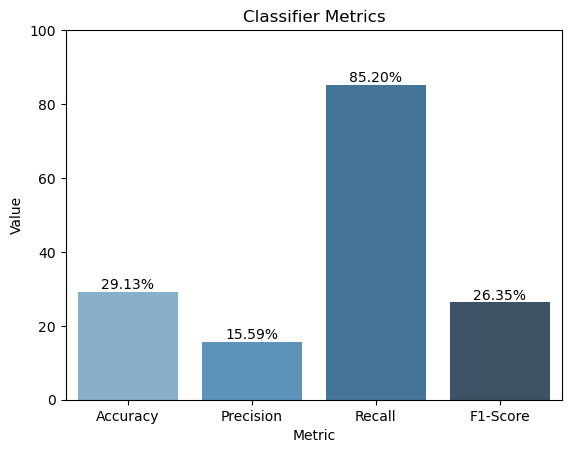

In [5]:
# calculate metrics of classifier 

file_path = path_to_folder + "Code\\Klenner&Göhring\\validation_data.csv"
test_data = pd.read_csv(file_path)

features = test_data['Nominal phrase']
labels = test_data['Animated']
labels = labels.astype(int)

# vectorization
features_vec = vectorizer.transform(features)

# prediction
predictions = classifier.predict(features_vec)

# compute metrics and plot them
accuracy = accuracy_score(labels, predictions)
report = classification_report(labels, predictions, output_dict=True)
precision = report['1']['precision']
recall = report['1']['recall']
f1_score = report['1']['f1-score']

metrics = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                        'Value': [accuracy*100, precision*100, recall*100, f1_score*100]})

ax = sns.barplot(x='Metric', y='Value', data=metrics, palette='Blues_d')
plt.ylim(0, 100)
plt.title('Classifier Metrics')

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.show()

In [6]:
conda list -e > "C:\\Users\\Anwender\\Desktop\\Code\\Klenner&Göhring\\requirements.txt"


Note: you may need to restart the kernel to use updated packages.


Das System kann den angegebenen Pfad nicht finden.
